In [1]:
from haystack import Pipeline
from haystack.components.builders import PromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.generators import OpenAIGenerator
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.rankers import TransformersSimilarityRanker
from haystack.utils import ComponentDevice

In [2]:
fetcher = LinkContentFetcher()
converter = HTMLToDocument()
document_splitter = DocumentSplitter(split_by="passage", split_length=10)
ranker = TransformersSimilarityRanker(device=ComponentDevice.from_str("cuda:0"), top_k=5, token=None)

In [3]:
template = """Given the information below, answer the query. Only use the 
provided context to generate the answer and output the used document links

    Context:

    {% for document in documents %}
        {{ document.content }}
        URL: {{ document.meta.url }}
    {% endfor %}

    Question: {{ query }}
    
    Answer:
"""

prompt_builder = PromptBuilder(template=template)
generator = OpenAIGenerator(model="gpt-4o-mini") # Feel free to try different models or different providers

In [4]:
# Hints:
# 1. One component is to split the documents into smaller chunks of 10 sentences each.
# 2. As the other component, consider methods or components you can use to filter
# out irrelevant chunks by ranking before injecting the context into the prompt

In [5]:
pipeline = Pipeline()
pipeline.add_component(name="fetcher", instance=fetcher)
pipeline.add_component(name="converter", instance=converter)
pipeline.add_component(name="splitter", instance=document_splitter)
pipeline.add_component(name="ranker", instance=ranker)
pipeline.add_component(name="prompt_builder", instance=prompt_builder)
pipeline.add_component(name="generator", instance=generator)

In [6]:
# Let's connect all the components.
pipeline.connect("fetcher.streams", "converter.sources")
pipeline.connect("converter.documents", "splitter.documents")
pipeline.connect("splitter.documents", "ranker.documents")
pipeline.connect("ranker.documents", "prompt_builder")
pipeline.connect("prompt_builder", "generator")

🚅 Components
  - fetcher: LinkContentFetcher
  - converter: HTMLToDocument
  - splitter: DocumentSplitter
  - ranker: TransformersSimilarityRanker
  - prompt_builder: PromptBuilder
  - generator: OpenAIGenerator
🛤️ Connections
  - fetcher.streams -> converter.sources (List[ByteStream])
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> ranker.documents (List[Document])
  - ranker.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> generator.prompt (str)

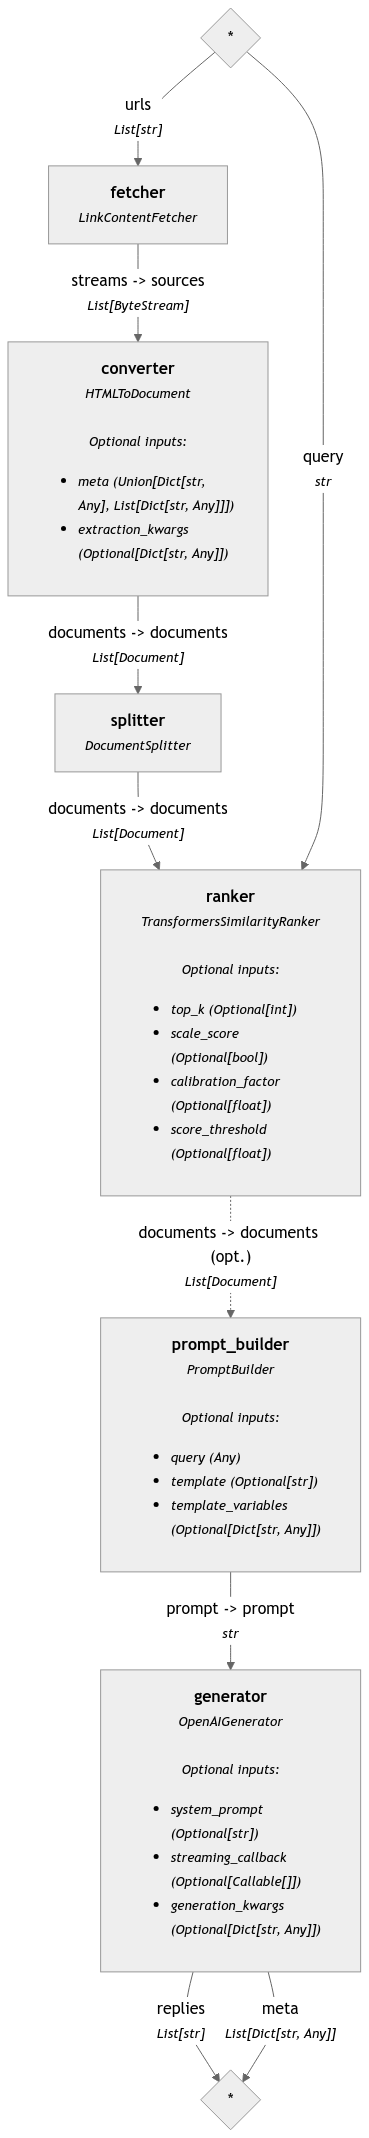

In [7]:
pipeline.show()

In [12]:
urls = [
    "https://haystack.deepset.ai/blog/extracting-metadata-filter",
    "https://haystack.deepset.ai/blog/query-expansion",
    "https://haystack.deepset.ai/blog/query-decomposition",
    "https://haystack.deepset.ai/cookbook/metadata_enrichment"
]

## Example queries you can try
# query = "What is the difference between metadata filtering and metadata enrichment?"
# query = "Which methods can I use to transform query for better retrieval?"
query = "How can I use metadata to improve retrieval?"
# query = "What's preprocessing?" # Should return no answer

In [13]:
result = pipeline.run(
    data={
        "fetcher": {"urls": urls},
        "ranker": {"query": query},
        "prompt_builder": {"query": query},
    }
)

In [14]:
print(result['generator']['replies'][0])

You can use metadata to improve retrieval by applying metadata filtering in Retrieval-Augmented Generation (RAG) applications. This approach narrows down the search space based on specific metadata attributes such as date, topic, or source, enhancing the relevance and accuracy of the retrieved documents. Here are the key benefits:

1. **Relevance**: Metadata filtering ensures that the generated responses are more aligned with specific queries or topics by limiting the information being retrieved.

2. **Accuracy**: Filtering based on metadata guarantees that the information used for generation is accurate and trustworthy, especially for applications where precision is critical.

3. **Efficiency**: By eliminating irrelevant or low-quality information, metadata filtering improves the efficiency of retrieval and reduces processing times.

To implement metadata filtering, you can either specify it directly in the retrieval process or extract it from user queries, allowing for more tailored 